# Imaging

Working order:
1. Take a galaxy with RA and DEC coordinates.
2. Find the galaxy in the JWST Cosmos-Web data release.
3. Image the galaxy in multiple wavelengths. Filters F115W, F150W, F277W, F444W are availible in NIRCam, F770W is in MIRI imaging.
4. Display the images in each wavelength.
5. Add a redshift label.
6. Output each object in a fits file with a data table of the corresponding object's data in the COSMOS2020 survey.

How to achieve this? We already have code to image galaxies. We need to know where they are in the image. We can use WCS in AstroPy. Which file are they in? We can write a code to find them.

The images in MIRI and NIRCam (EPOCH 2, EPOCH 1 has a single region) are divided into 10 sections labeled A# where # is the number of the section. We have bounds for those, and can use those to check if the object is in which file. We could have the program give us a list of the galaxies which we have a picture of, and which section it is in. With that, we need to think of how we want to iterate through those galaxies.\
\
We could:
* Iterate through a list of all of the galaxies, take the section number, and get images of its coordinates in each band, and then move to the next object. [BAD!!] This is bad due to the fact that we would have to open and close each section image everytime we swapped an object.
* Iterate through 10 seperate lists for each section, by doing more work in the identification code, giving us 10 different lists, that pertain to the galaxies in each section. This is more promising. (E.G. this is all the galaxies in A2, open A2, take a picture of these galaxies.)

Problems:
* Galaxies might be on the edge of the image!!
* Watch out for galaxies in sections of the image where there are nan or 0 values, or pixels outside of the array.
* MIRI F770W has large swaths cut out.

Notes:
* Our check for if the object is in the section, overestimates the size of the section. There are parts where there is NO data in the regions we have. This is fixed by checking if there is any data at the coordinates first. May introduce problems later.

Our ranges:\
Section&emsp;ramin&emsp;ramax&emsp;decmin&emsp;decmax\
A1&emsp;149.7198796&emsp;149.9413496&emsp;2.0856512&emsp;2.3354095\
A2&emsp;149.8554506&emsp;150.07693&emsp;2.0363591&emsp;2.2861269\
A3&emsp;149.9910155&emsp;150.2125019&emsp;1.9870553&emsp;2.2368306\
A4&emsp;150.1265729&emsp;150.3480637&emsp;1.9377408&emsp;2.1875215\
A5&emsp;150.2621212&emsp;150.4836139&emsp;1.8884166&emsp;2.1382005\
A6&emsp;149.6540746&emsp;149.8755087&emsp;1.9048087&emsp;2.1545612\
A7&emsp;149.7896293&emsp;150.011074&emsp;1.8555218&emsp;2.1052826\
A8&emsp;149.9251788&emsp;150.1466316&emsp;1.8062243&emsp;2.0559913\
A9&emsp;150.0607214&emsp;150.2821799&emsp;1.7569171&emsp;2.0066883\
A10&emsp;150.1962556&emsp;150.4177173&emsp;1.7076011&emsp;1.9573744\
E1&emsp;149.7957016&emsp;150.0459284&emsp;2.1872638981167607&emsp;2.487277171724028

In [2]:
range = pd.read_csv('fits/sectionrange.txt',sep='\t',header=0)
range

NameError: name 'pd' is not defined

We should collect data from the COSMOS2020 survey within a box with center (150.1,2.1) with a width and height of 0.6 degrees to be safe. This gives us 195k sources to find.

Our routine is:\
Loop Object:\
&emsp;Loop File:\
&emsp;&emsp;If is fits file:\
&emsp;&emsp;&emsp;Is in ra?:\
&emsp;&emsp;&emsp;&emsp;Is in dec?:\
&emsp;&emsp;&emsp;&emsp;&emsp;Is obj pixel in image pixel range?:\
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Take picture\
\
We (hopefully) don't need the weight filter as the data doesn't have large swaths missing, and if it does (hopefully) imshow will just print them blank.


In [26]:
from astropy.io import fits
h1 = fits.getheader('fits/nircam/A1/mosaic_nircam_f150w_COSMOS-Web_60mas_A1_v0_5_i2d.fits.gz',ext=1)
h2 = fits.getheader('fits/nircam/A2/mosaic_nircam_f277w_COSMOS-Web_60mas_A2_v0_5_i2d.fits.gz',ext=1)

In [35]:
print(h1['NAXIS1'])
print(h2['NAXIS2'])

9600
12455


In [29]:
from astropy.io import fits
from os import listdir

import warnings
warnings.filterwarnings("ignore")

# Define the path to the FITS files
path = r"/home/eliasw/OneDrive/Research/Deconvolution/fits/headers"

# Preload FITS headers and data
def preload_fits_files(path):
    fits_data = {}
    for file in listdir(path):
        if file.endswith('.fits.gz'):  # Ensure it's a FITS file
            header = WCS(fits.getheader(path + '/' + file, ext=1), fix=False)  # Get WCS header for pixel to RA/Dec conversion
            fits_data[(file.replace('mosaic_nircam_f115w_COSMOS-Web_60mas_',"").replace('_v0_5_i2d.fits.gz',''))] = {'wcs': header}
    return fits_data

In [32]:
fits_data = preload_fits_files(path)

In [33]:
fits_data.keys()

dict_keys(['A2', 'A6', 'E1', 'A10', 'A1', 'A9', 'A4', 'A8', 'A7', 'A3', 'A5'])

In [ ]:
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from os import listdir
import multiprocessing as mp

import warnings
warnings.filterwarnings("ignore")

# Define the path to the FITS files
path = r"/home/eliasw/OneDrive/Research/Deconvolution/"

# Load the galaxy data and FITS file ranges
obj = pd.read_csv('input/trimCOSMOS2020.csv', sep=',', header=0)
ranges = pd.read_csv('fits/sectionrange.txt', sep='\t', header=0)

def preload_fits_files(path):
    fits_data = {}
    for file in listdir(path):
        if file.endswith('.fits.gz'):  # Ensure it's a FITS file
            header = fits.getheader(path + '/' + file,ext=1)
            wheader = WCS(fits.getheader(path + '/' + file, ext=1), fix=False)  # Get WCS header for pixel to RA/Dec conversion
            fits_data[(file.replace('mosaic_nircam_f115w_COSMOS-Web_60mas_',"").replace('_v0_5_i2d.fits.gz',''))] = {'wcs': wheader,'header':header}
    return fits_data

# Function to search for galaxies in preloaded FITS files for a subset of galaxies
def search_galaxies(start_index, end_index, fits_data):
    foundgals = 0
    found_objects = []
        
    end_index = min(end_index, len(obj)) #indexing fix
    #print(f"Processing indices from {start_index} to {end_index}")

    for i in range(start_index, end_index):
       # print(f"Checking index {i}, Galaxy ID {obj['Classic'][i]}") 
        for section, file_data in fits_data.items():  # Loop through preloaded FITS data
            ramin = float(ranges[ranges['Section'] == section]['RAmin'])
            ramax = float(ranges[ranges['Section'] == section]['RAmax'])
            decmin = float(ranges[ranges['Section'] == section]['DECmin'])
            decmax = float(ranges[ranges['Section'] == section]['DECmax'])
            # Check if the galaxy is within the RA/Dec range of the file
            if ramin <= obj['RAJ2000'][i]:
                if obj['RAJ2000'][i] <= ramax:
                    if decmin <= obj['DEJ2000'][i]:
                        if obj['DEJ2000'][i] <= decmax:
                            w = file_data['wcs']  # Get the preloaded WCS header
                            xpix, ypix = w.all_world2pix(obj['RAJ2000'][i], obj['DEJ2000'][i], 1)
                            # Check if the pixel coordinates are within bounds
                            if (0 <= xpix <= file_data['header']['NAXIS1'] and 0 <= ypix <= file_data['header']['NAXIS2']):
                                foundgals += 1
                                #print(f"Galaxy found at index {i}, ID {obj['Classic'][i]} in file {file}, at coords {obj['RAJ2000'][i]} RA and {obj['DEJ2000'][i]} DEC")
                                found_objects.append([obj['Classic'][i], obj['RAJ2000'][i], obj['DEJ2000'][i], obj['lpzBEST'][i], section])  # Save RA, Dec, and file
                                break  # Stop searching this file if galaxy found
    
    return foundgals, found_objects

# Multi-core processing: split the galaxy list into chunks
if __name__ == '__main__':
    num_cores = mp.cpu_count() - 2  # Use all available cores
    chunk_size = len(obj) // num_cores  # Determine the size of each chunk

    # Preload all FITS files and headers before starting the search
    fits_data = preload_fits_files(path + '/fits/headers')

    # Create a pool of workers and distribute the work
    with mp.Pool(num_cores) as pool:
        results = [pool.apply_async(search_galaxies, args=(i, i + chunk_size, fits_data)) for i in range(0, len(obj), chunk_size)]
        found_gals = 0
        found_objects = []

        for result in results:
            chunk_found_gals, chunk_found_details = result.get()  # Get both elements from the result tuple
            found_gals += chunk_found_gals  # Sum the galaxy count
            found_objects.extend(chunk_found_details)  # Add the found details to the main list

        # Write the results to a file
        with open('output/found_galaxies_section.txt', 'w') as out:
            out.write(f'Found {found_gals} galaxies out of {len(obj)}\n')
            out.write('ID\tRAJ2000\tDEJ2000\tlpzBEST\tSection\n')  # Header for the galaxy details
            for gal in found_objects:
                out.write(f'{gal[0]}\t{gal[1]}\t{gal[2]}\t{gal[3]}\t{gal[4]}\n')  # Write each galaxy's details (RA, Dec, and file)
            out.flush()

Program ran in 3-4 minutes and found 140106 galaxies out of 195896.. Hmmm. This is a lot.

Let's split it into groups for sections.

In [10]:
import pandas as pd
gals = pd.read_csv('output/found_galaxies_section.txt',delimiter='\t',skiprows=1,header=0)

In [11]:
gals

,ID,RAJ2000,DEJ2000,lpzBEST,Section
0,435874,150.389385,1.834678,NaN,A10
1,430463,150.391391,1.834311,0.3673,A10
2,430668,150.392040,1.833619,2.1733,A10
3,432128,150.392935,1.835029,2.2295,A10
4,431170,150.390563,1.834566,1.5188,A10
...,...,...,...,...,...
140101,1050409,149.911639,2.414601,1.0349,E1
140102,1051202,149.911516,2.415344,1.8881,E1
140103,1051487,149.911057,2.415539,3.8172,E1
140104,1051830,149.908965,2.416034,0.4271,E1


In [1]:
A1 = gals[gals['Section']=='A1']
A1

NameError: name 'gals' is not defined

In [16]:
A1.to_csv('fits/nircam/A1/A1.txt',sep='\t',index=False)

In [17]:
for sec in ['A2', 'A6', 'E1', 'A10', 'A1', 'A9', 'A4', 'A8', 'A7', 'A3', 'A5']:
    section = gals[gals['Section']==sec]
    section.to_csv('fits/nircam/'+sec+'/'+sec+'.txt',sep='\t',index=False)

In [3]:
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from os import listdir
import multiprocessing as mp
# read in section lists
sections = {}
for sec in ['A2', 'A6', 'E1', 'A10', 'A1', 'A9', 'A4', 'A8', 'A7', 'A3', 'A5']:
    sections.update({sec : pd.read_csv('fits/nircam/'+sec+'/'+sec+'.txt',sep='\t',header=0)})

In [4]:
sections.keys()
sections['A2']

,ID,RAJ2000,DEJ2000,lpzBEST,Section
0,643248,150.001060,2.038389,1.9093,A2
1,646217,150.000174,2.039420,1.0575,A2
2,651040,149.998478,2.039578,NaN,A2
3,645867,149.996780,2.040563,1.9200,A2
4,646127,149.998664,2.040637,0.0717,A2
...,...,...,...,...,...
18875,908124,149.934824,2.281722,3.3369,A2
18876,908340,149.935379,2.282513,0.2634,A2
18877,908561,149.934026,2.282736,1.3869,A2
18878,909288,149.934767,2.282932,1.7704,A2


Set DATE-AVG to '2023-04-10T18:28:23.760' from MJD-AVG.
Set DATE-END to '2023-04-15T08:28:40.266' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     2.619427 from OBSGEO-[XYZ].
Set OBSGEO-H to 1259953936.907 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/tmp/ipykernel_65257/4269527690.py:38: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  list_axes[n].imshow(pics[band][down:up,left:right],cmap='gray',vmin=0,vmax=0.25,origin='lower')


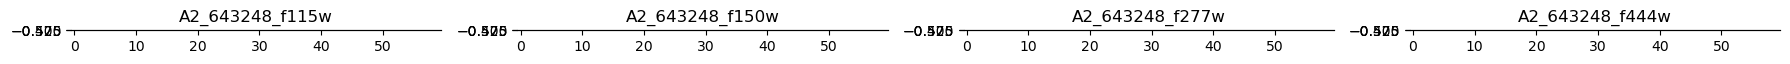

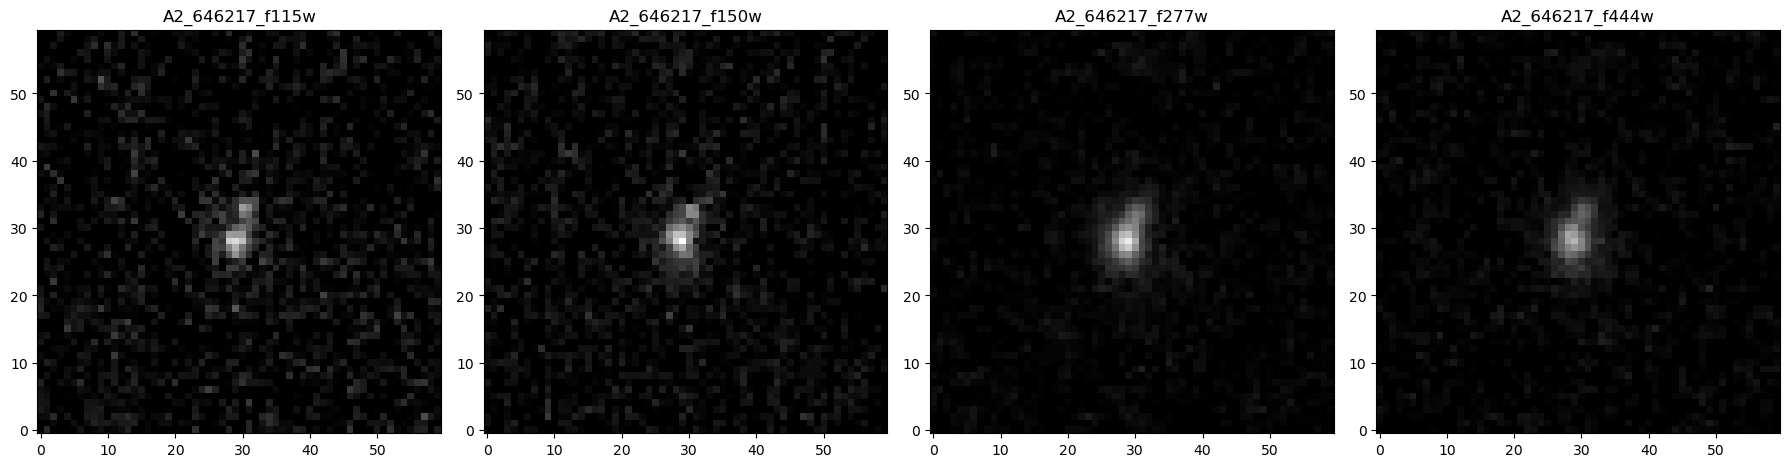

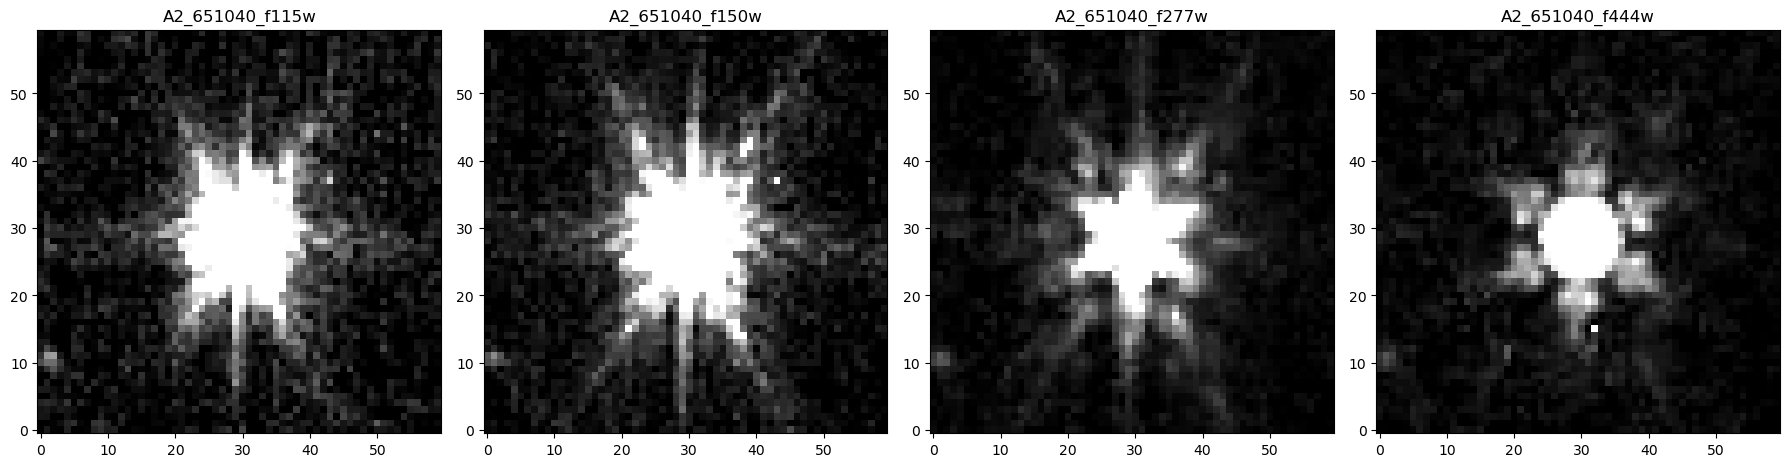

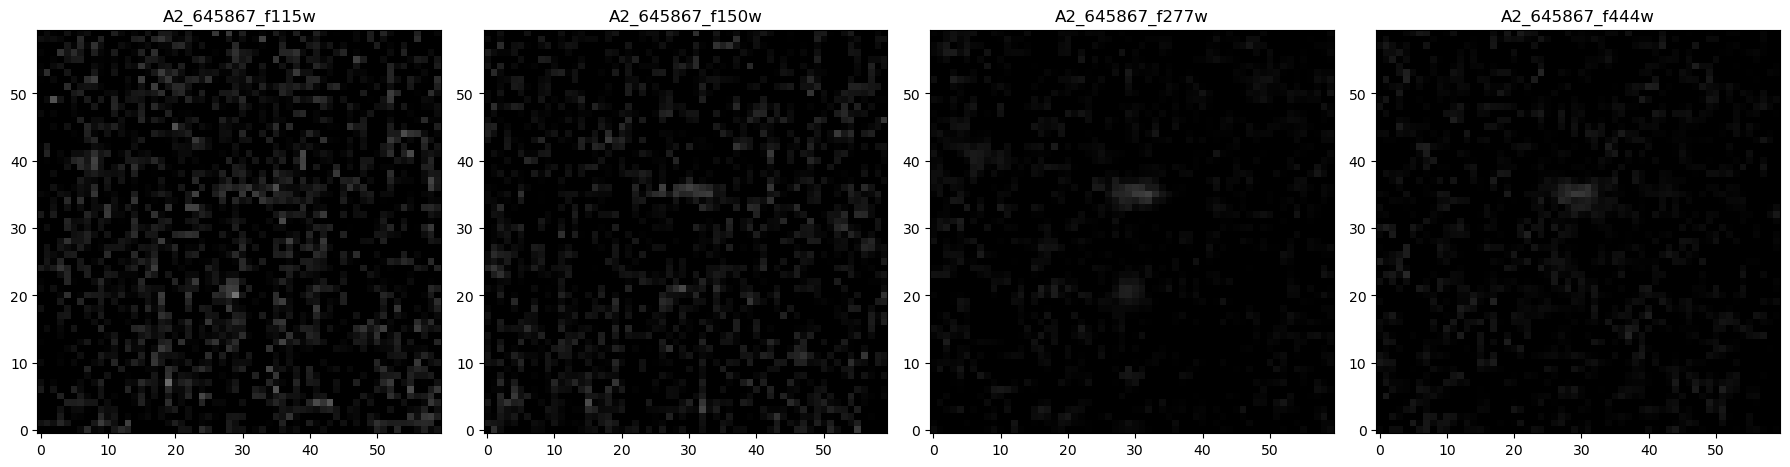

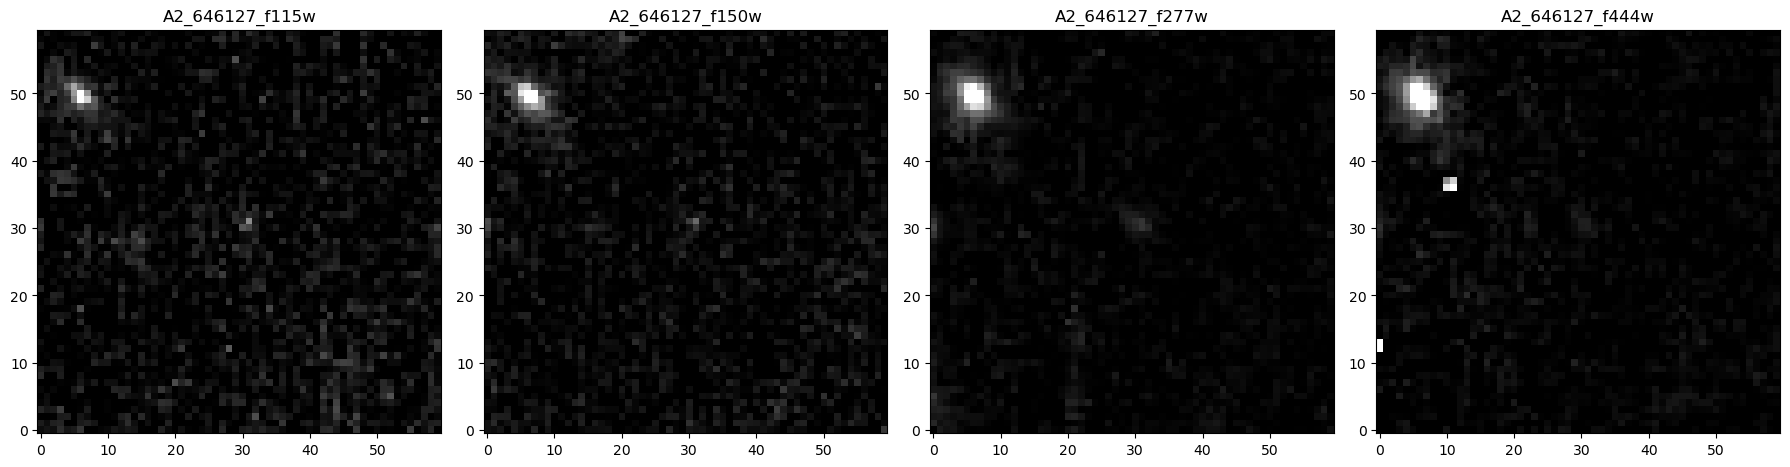

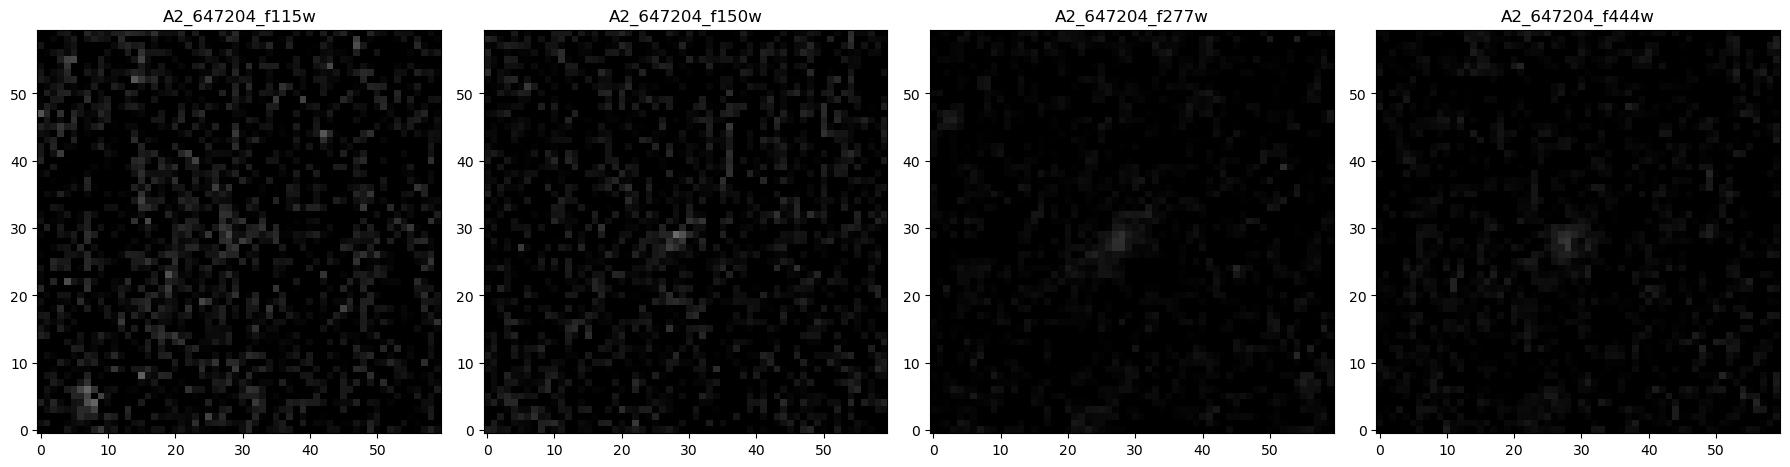

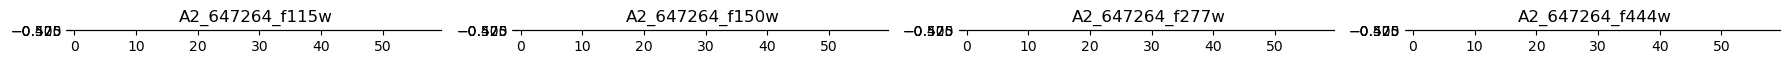

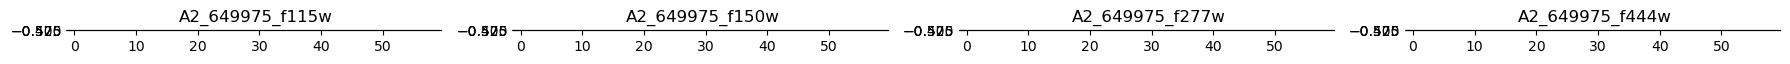

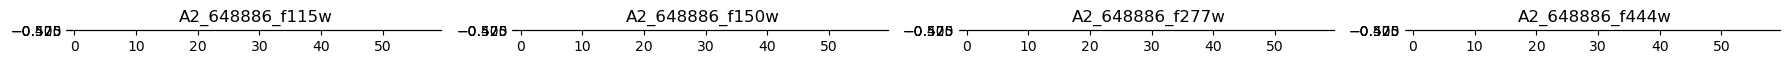

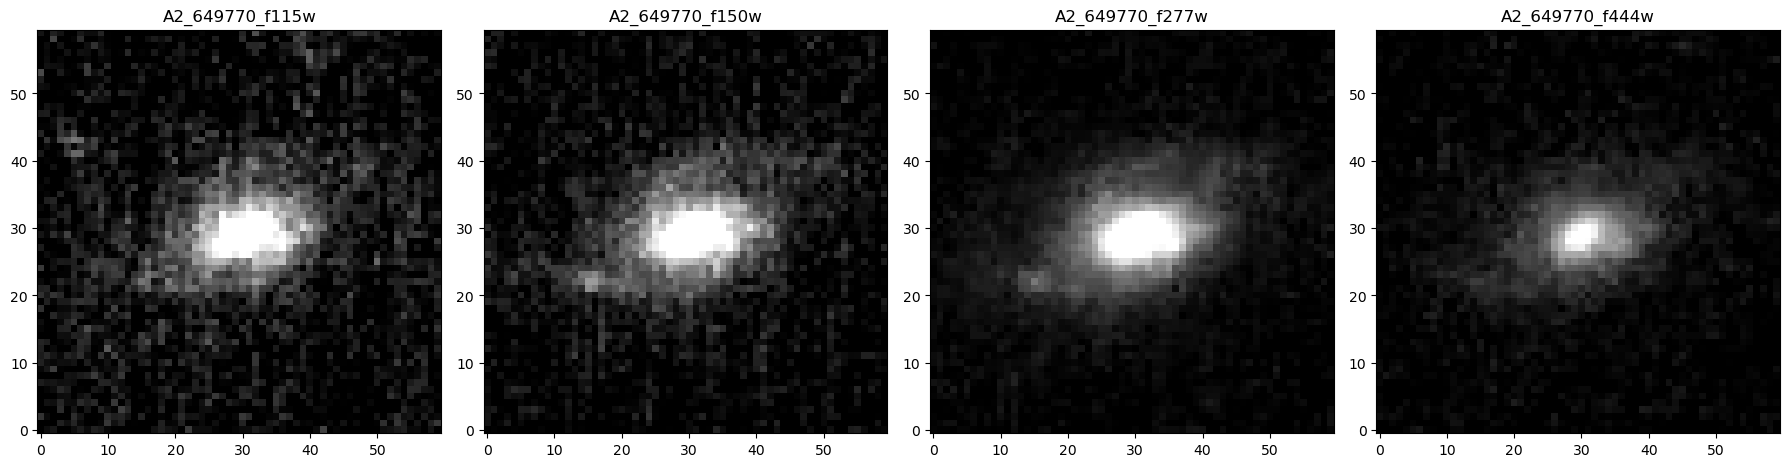

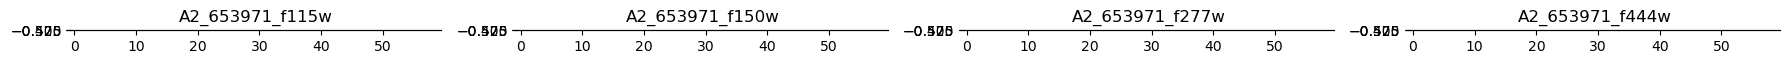

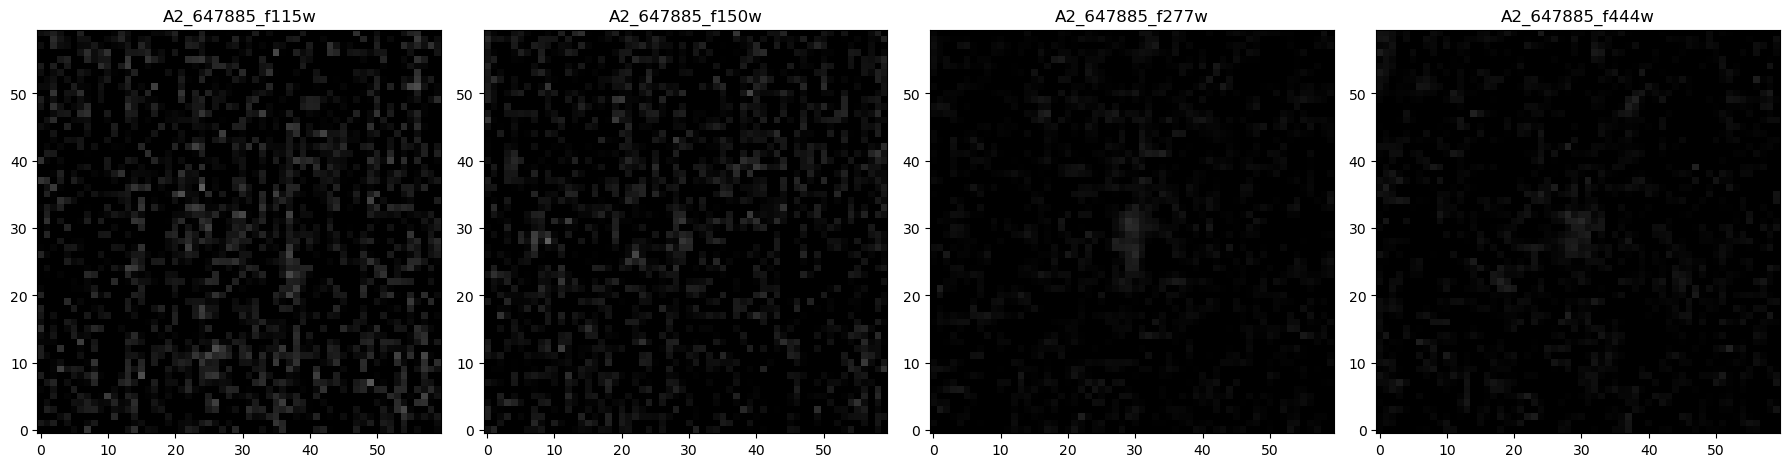

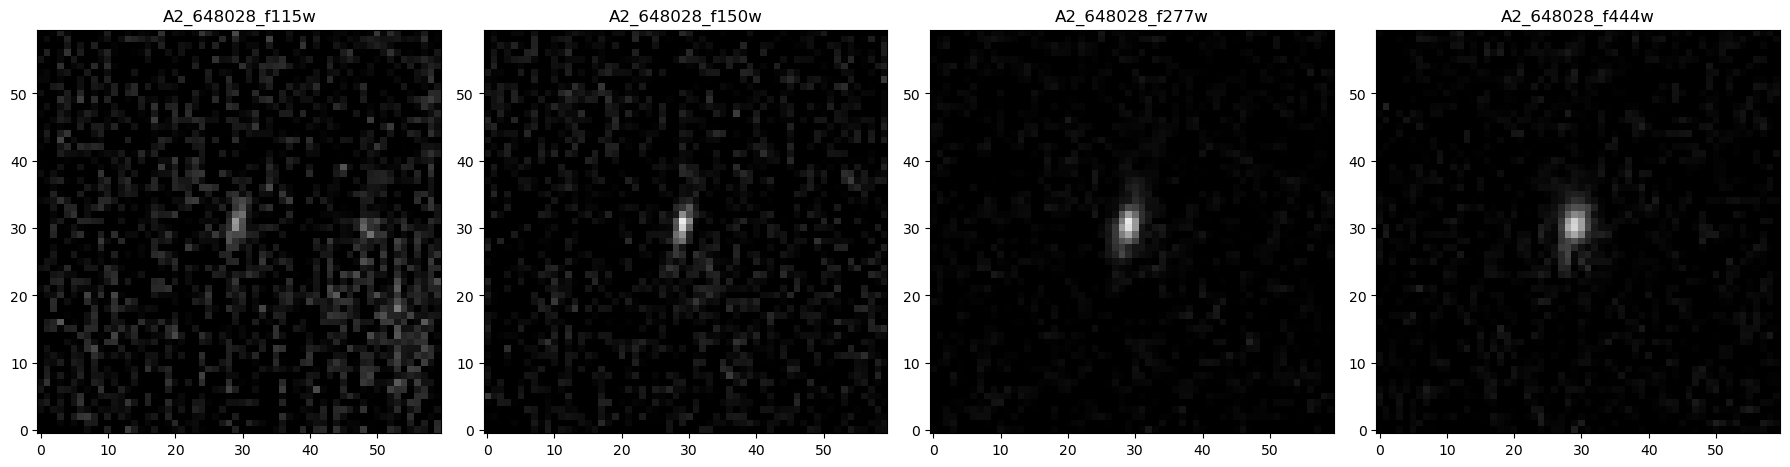

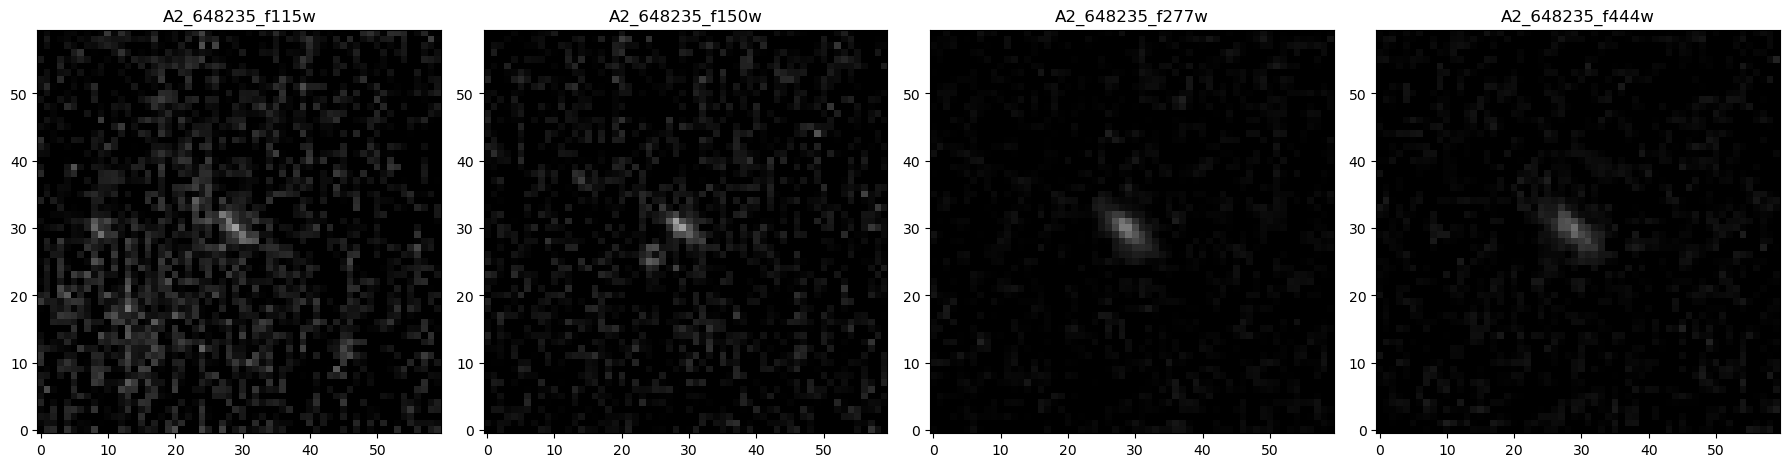

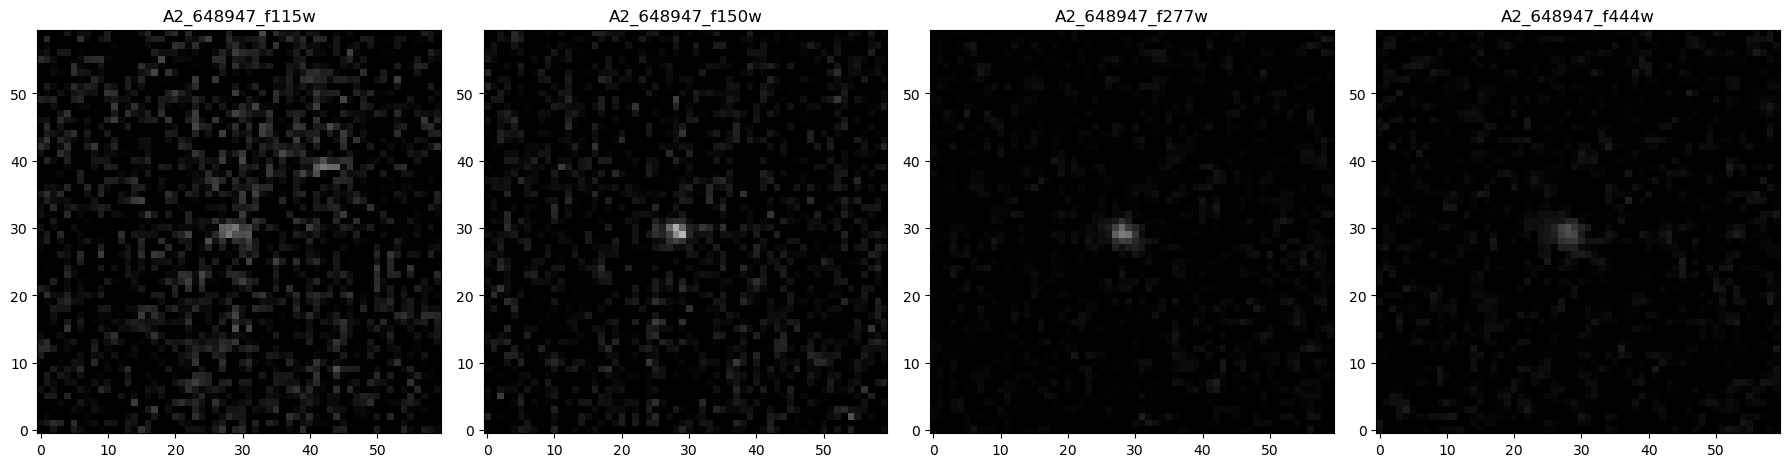

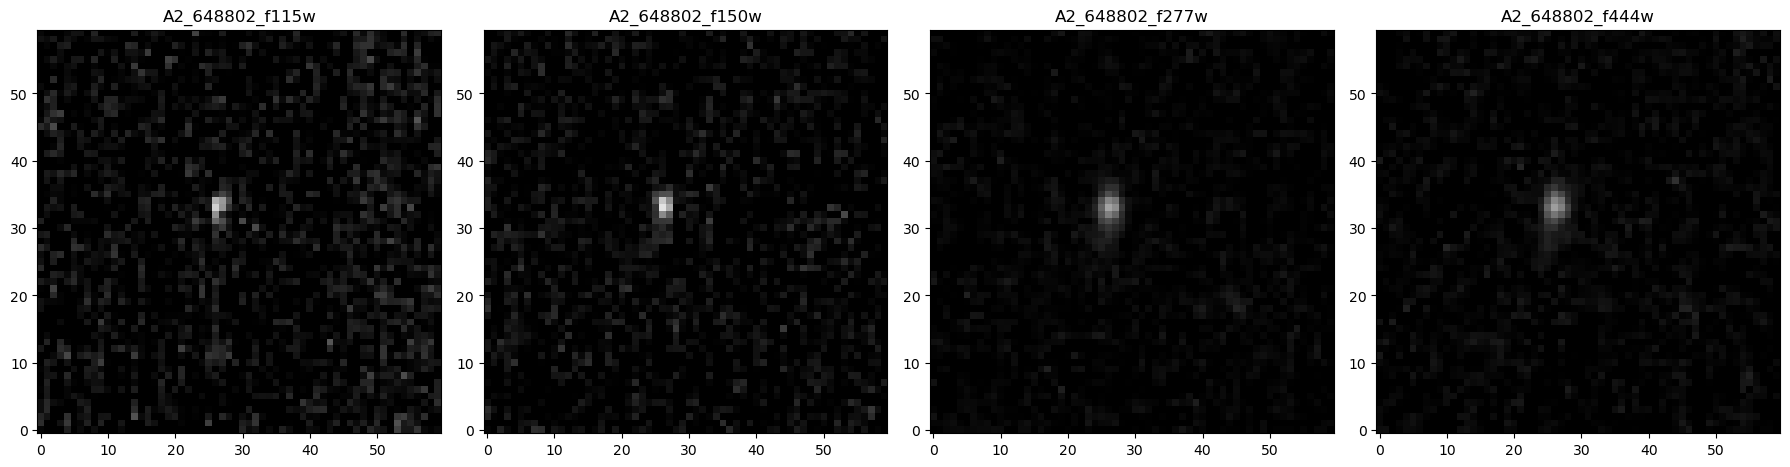

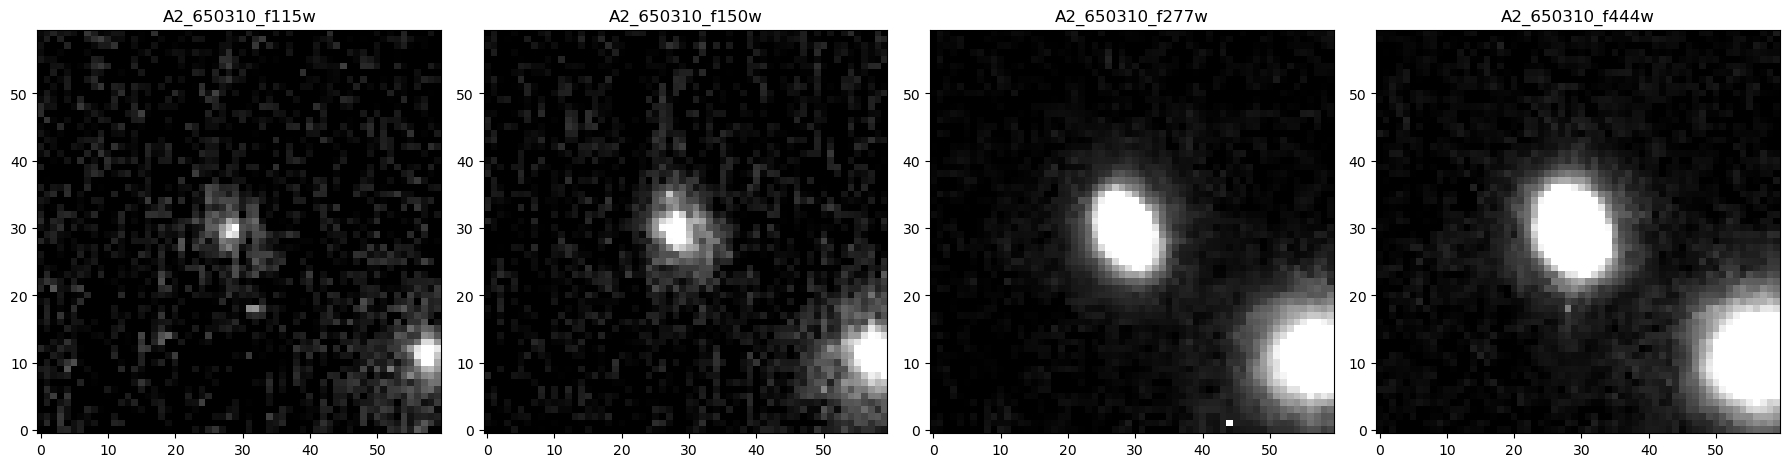

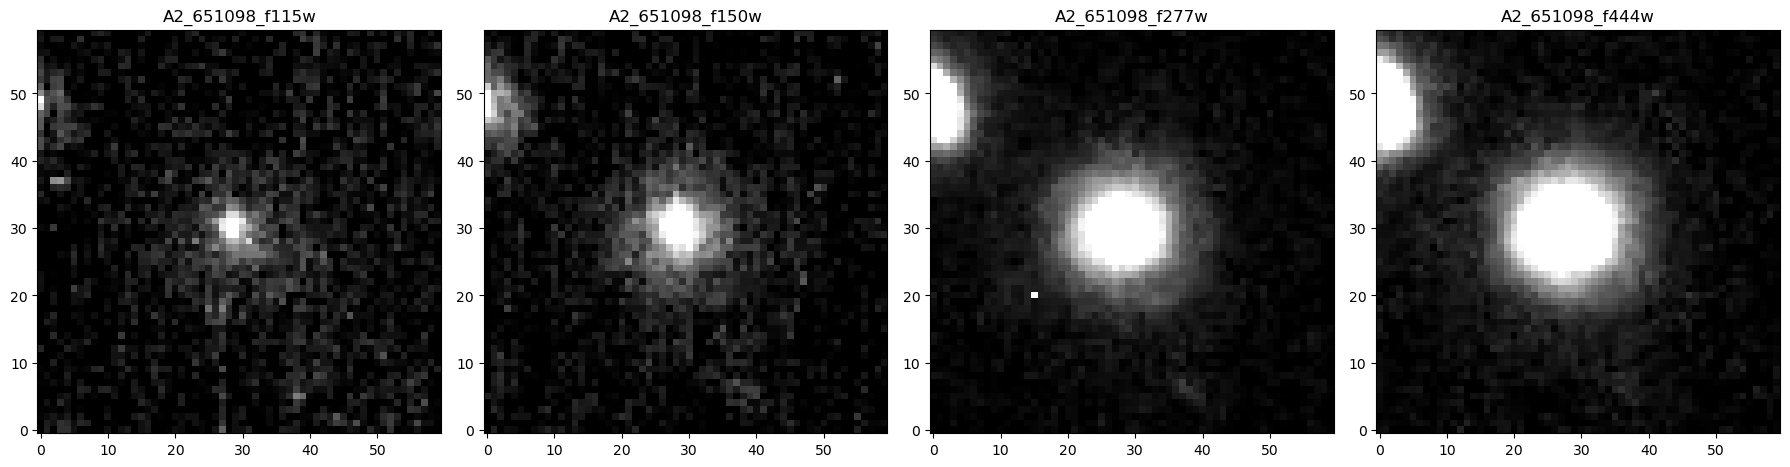

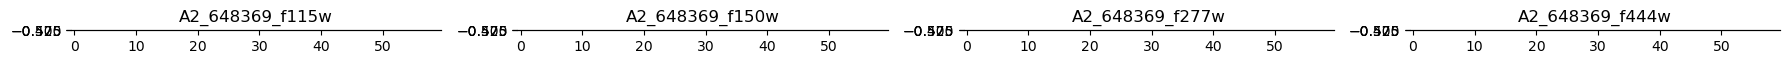

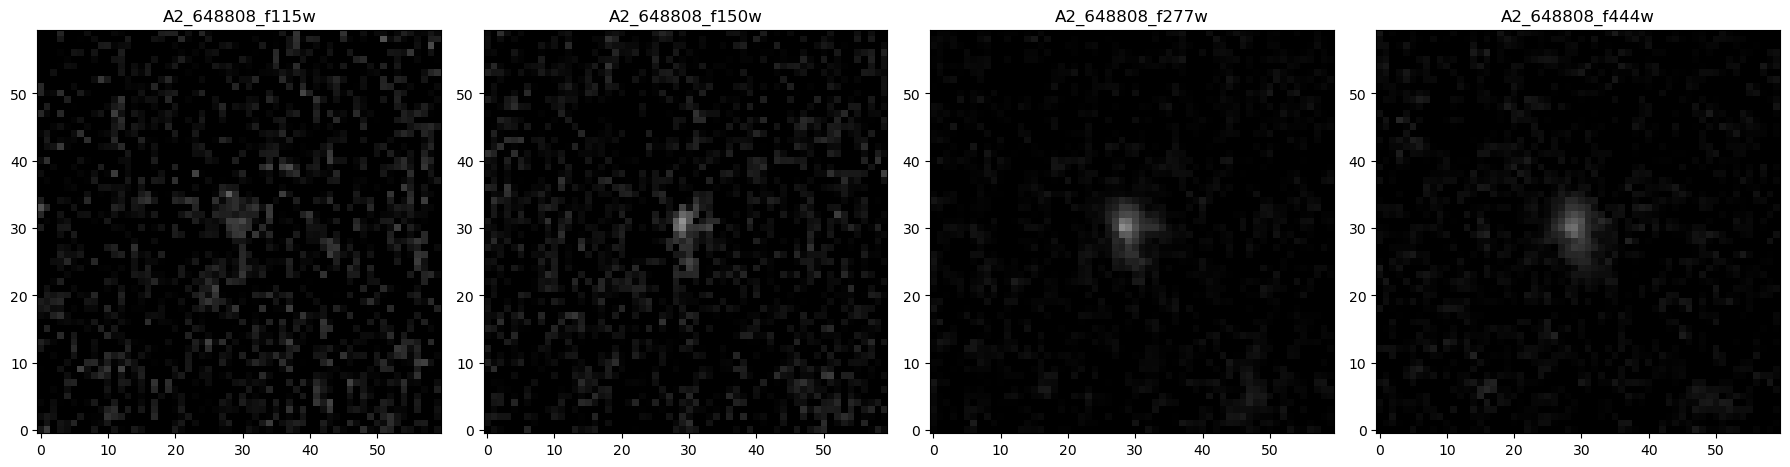

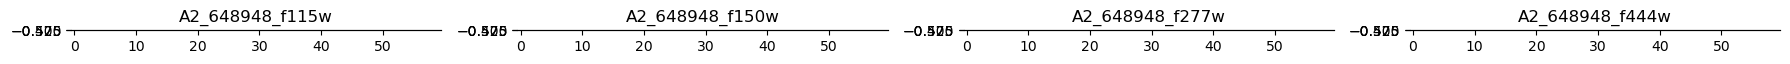

KeyboardInterrupt: 

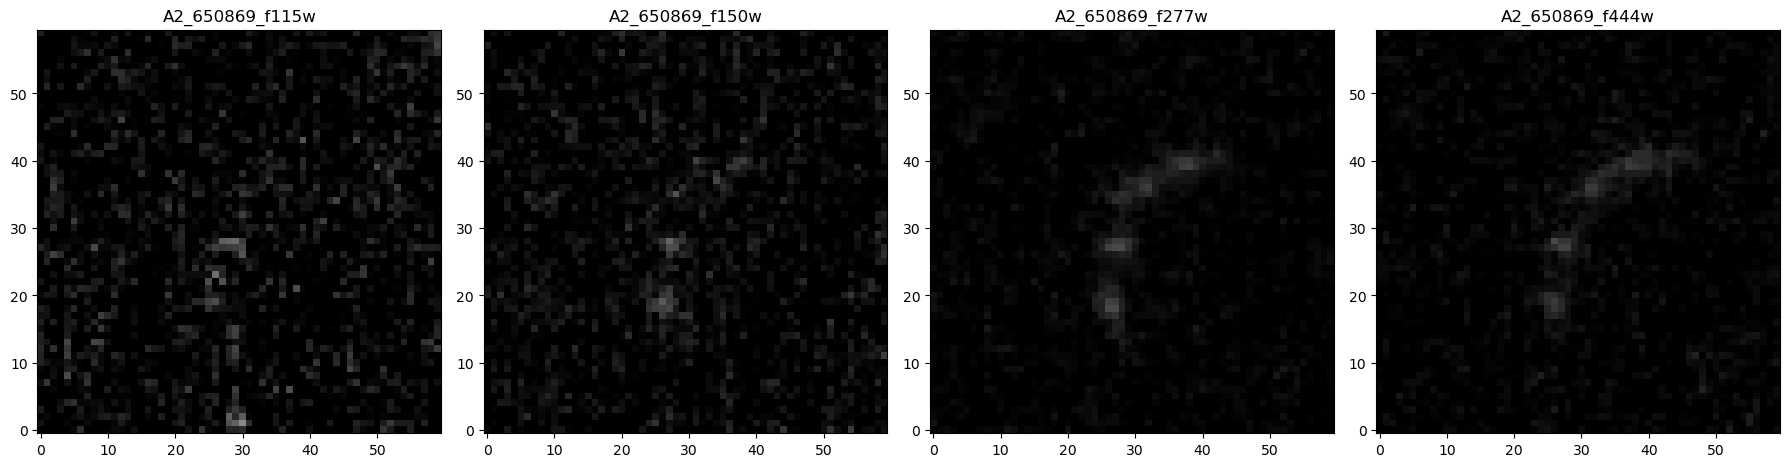

In [5]:
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from os import listdir
import matplotlib.pyplot as plt
import multiprocessing as mp
# read in section lists
sections = {}
for sec in ['A2', 'A6', 'E1', 'A10', 'A1', 'A9', 'A4', 'A8', 'A7', 'A3', 'A5']:
    sections.update({sec : pd.read_csv('fits/nircam/'+sec+'/'+sec+'.txt',sep='\t',header=0)})

for sec in ['A2', 'A6', 'E1', 'A10', 'A1', 'A9', 'A4', 'A8', 'A7', 'A3', 'A5']:
    pics = {}
    for band in ['115','150','277','444']:
        pics.update({band : fits.getdata('fits/nircam/'+sec+'/'+'mosaic_nircam_f'+band+'w_COSMOS-Web_60mas_'+sec+'_v0_5_i2d.fits.gz',ext=1)})
    w = WCS(fits.getheader('fits/nircam/'+sec+"/mosaic_nircam_f150w_COSMOS-Web_60mas_"+sec+'_v0_5_i2d.fits.gz',ext=1))
    for i in range(len(sections[sec])):
        num_images  = 4
        num_cols    = 4
        num_rows    = 1
        # Create a grid of subplots.
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(18,5))
        list_axes = list(axes.flat)
        for n,band in enumerate(['115','150','277','444']): # for each object
            xpix, ypix = w.all_world2pix(sections[sec]['RAJ2000'][i],sections[sec]['DEJ2000'][i],1) # convert from RA/DEC to pixel position
            xpix = round(float(xpix))
            ypix = round(float(ypix))
            rpix = round(float(30)) # arcsec / 3600 = deg / (pix/deg) = pix radius
            #print(xpix,ypix,rpix) # debug print file values
            # get image bounds for stamp
            left = int((xpix-rpix))
            right = int((xpix+rpix))
            down = int((ypix-rpix))
            up = int((ypix+rpix))
            #print(left,right,up,down) # debug print image bounds
            # crop image with matplotlib
            list_axes[n].imshow(pics[band][down:up,left:right],cmap='gray',vmin=0,vmax=0.25,origin='lower')
            list_axes[n].set_title(f'{sec}_{sections[sec]['ID'][i]}_f{band}w')
        plt.tight_layout()
        plt.savefig(f'output/{sec}/{sec}_{sections[sec]['ID'][i]}_allbands',dpi=75)
        plt.show()

In [70]:
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from os import listdir
import matplotlib.pyplot as plt
import multiprocessing as mp
ID = 'BigGuy'
RA = 150.424952
DEC = 2.066195
sec = 'A5'
pics = {}
for band in ['115','150','277','444']:
    pics.update({band : fits.getdata('fits/nircam/'+sec+'/'+'mosaic_nircam_f'+band+'w_COSMOS-Web_60mas_'+sec+'_v0_5_i2d.fits.gz',ext=1)})
w = WCS(fits.getheader('fits/nircam/'+sec+"/mosaic_nircam_f150w_COSMOS-Web_60mas_"+sec+'_v0_5_i2d.fits.gz',ext=1))
for band in ['115','150','277','444']:
    xpix, ypix = w.all_world2pix(RA,DEC,1) # convert from RA/DEC to pixel position
    xpix = round(float(xpix))
    ypix = round(float(ypix))
    rpix = round(float(200)) # arcsec / 3600 = deg / (pix/deg) = pix radius
    #print(xpix,ypix,rpix) # debug print file values
    # get image bounds for stamp
    left = int((xpix-rpix))
    right = int((xpix+rpix))
    down = int((ypix-rpix))
    up = int((ypix+rpix))
    #print(left,right,up,down) # debug print image bounds
    # fits file saving
    outfile = f'output/{ID}/f{band}w_60mas_{ID}.fits' # prepare outbound filename
    prihdu = fits.PrimaryHDU() # set up primary first HDU
    # prihdu.data = fits.getdata('fits/nircam/'+sec+'/'+'mosaic_nircam_f'+band+'w_COSMOS-Web_60mas_'+sec+'_v0_5_i2d.fits.gz',ext=0) # carry over data from original HDU
    prihdu.header = fits.getheader('fits/nircam/'+sec+'/'+'mosaic_nircam_f'+band+'w_COSMOS-Web_60mas_'+sec+'_v0_5_i2d.fits.gz',ext=0) # carry over header from original HDU
    prihdu.header.update(w[down:up,left:right].to_header()) # crop original data in HDU to fit our new image range
    scihdu = fits.ImageHDU() # set up sci HDU
    scihdu.data = pics[band][down:up,left:right] # carry over data from original image, cropped to our bounds
    scihdu.header = fits.getheader('fits/nircam/'+sec+'/'+'mosaic_nircam_f'+band+'w_COSMOS-Web_60mas_'+sec+'_v0_5_i2d.fits.gz',ext=1) # carry over data from original sci header
    scihdu.header.update(w[down:up,left:right].to_header()) # crop data in sci header to our new bounds using WCS function and bounds
    hdulist = fits.HDUList([prihdu, scihdu]) # put both hdu's in hdulist
    hdulist.writeto(outfile, overwrite=True) # save hdu's in new fits file

Set DATE-AVG to '2023-04-10T16:59:54.367' from MJD-AVG.
Set DATE-END to '2023-04-14T09:17:44.411' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -1.690731 from OBSGEO-[XYZ].
Set OBSGEO-H to 1287437314.672 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [1]:
import numpy as np
import pandas as pd

In [21]:
photo = pd.read_csv('input/COSMOSPhotometric.csv',sep=',',header=0)
photo

,Classic,RAJ2000,DEJ2000,FCFHTu,FHSCg,HSCimagAuto,FUVISTAY,UVISTAKsmagAuto,FSCIB427,FIRACCH1,...,lpzBEST,EZzphot,lpzPDF,lpzMinChi2,loglpSFRbest,loglpMassbest,logEZMass,E(B-V),ACSAWorld,ACSmuClass
0,422183,150.421868,1.825284,0.14,0.24,25.1191,0.29,23.5803,0.15,1.69,...,2.0712,2.243076,2.0712,2.130,1.0390,9.75824,9.98990,0.016,0.000030,1.0
1,422082,150.424285,1.825244,0.12,0.14,25.6168,0.09,24.9225,0.13,0.34,...,1.9478,0.428880,1.9478,2.141,0.3402,8.90841,8.20307,0.016,0.000025,1.0
2,421347,150.422824,1.825205,0.03,0.03,27.1165,0.05,26.5906,0.02,0.14,...,1.6298,1.157987,1.6298,1.213,0.0554,8.15241,8.52076,0.016,NaN,NaN
3,422381,150.423953,1.826342,0.02,0.01,28.0803,0.16,25.9231,0.02,0.02,...,1.6155,0.384434,1.6155,0.345,-0.9762,7.88989,6.32883,0.016,NaN,NaN
4,422322,150.424297,1.826240,0.02,0.02,27.4462,0.24,25.3933,0.02,0.05,...,4.9905,6.968220,4.9905,6.889,1.0940,8.43089,8.34027,0.016,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206410,1059553,150.087354,2.423573,0.04,0.03,27.2430,0.08,25.5506,0.05,0.08,...,NaN,0.580677,1.4845,1.291,-0.4016,7.91707,7.82225,0.015,NaN,NaN
206411,1060665,150.087847,2.424404,0.10,0.15,25.8200,0.17,25.3642,0.08,0.25,...,NaN,0.866982,0.9968,1.006,0.1118,7.73601,8.21373,0.015,0.000024,1.0
206412,1061380,150.087158,2.424674,0.30,0.44,24.6444,0.60,23.9423,0.38,0.76,...,NaN,NaN,0.0316,0.043,-2.6590,5.25004,NaN,0.015,0.000031,1.0
206413,1062154,150.086785,2.424940,0.31,0.38,24.5875,0.89,23.5497,0.29,1.46,...,NaN,NaN,0.0108,0.015,NaN,NaN,NaN,0.015,0.000030,1.0


In [38]:
def find_closest(df, column, value):
    return df.loc[(df[column] - value).abs().idxmin()]

In [2]:
def find_closest_values(df, target_value1, target_value2, col1, col2):
    df['distance'] = np.sqrt((df[col1] - target_value1)**2 + (df[col2] - target_value2)**2)
    return df.loc[df['distance'].idxmin()]

In [5]:
find_closest_values(photo,150.424830,2.0665166,'RAJ2000','DEJ2000')

Classic            662332.000000
RAJ2000               150.424952
DEJ2000                 2.066195
FCFHTu                 93.960000
FHSCg                 401.430000
HSCimagAuto            16.086900
FUVISTAY             2126.060000
UVISTAKsmagAuto        15.112900
FSCIB427              167.150000
FIRACCH1             1653.120000
FIRACCH2             1176.730000
FGALEXFUV              11.440000
Farmer             361279.000000
lpzBEST                      NaN
EZzphot                 0.123988
lpzPDF                  0.150100
lpzMinChi2              0.150000
loglpSFRbest           -0.596100
loglpMassbest          11.383300
logEZMass              11.011100
E(B-V)                  0.016000
ACSAWorld               0.000909
ACSmuClass              1.000000
distance                0.000344
Name: 63179, dtype: float64

Find one galaxy from 2 values and make a fits extention of it with each band.

In [3]:
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from os import listdir
import matplotlib.pyplot as plt
import multiprocessing as mp

photo = pd.read_csv('input/COSMOSPhotometric.csv',sep=',',header=0)
obj = find_closest_values(photo,150.424830,2.0665166,'RAJ2000','DEJ2000')
sec = 'A5'
CDELT1 = fits.getheader('fits/nircam/'+sec+"/mosaic_nircam_f150w_COSMOS-Web_60mas_"+sec+'_v0_5_i2d.fits.gz',ext=1)['CDELT1']
# Photometric Data Table
gal = photo[photo['Classic']==obj['Classic']]

def bounds(obj,CDELT1):
    xpix, ypix = w.all_world2pix(obj['RAJ2000'],obj['DEJ2000'],1) # convert from RA/DEC to pixel position
    xpix = round(float(xpix))
    ypix = round(float(ypix))
    rpix = round(obj['ACSAWorld']/CDELT1) # arcsec / 3600 = deg / (pix/deg) = pix radius
    #print(xpix,ypix,rpix) # debug print file values
    # get image bounds for stamp
    left = int((xpix-rpix))
    right = int((xpix+rpix))
    down = int((ypix-rpix))
    up = int((ypix+rpix))
    return left,right,up,down

pics = {}

for band in ['115','150','277','444']:
    pics.update({band : fits.getdata('fits/nircam/'+sec+'/'+'mosaic_nircam_f'+band+'w_COSMOS-Web_60mas_'+sec+'_v0_5_i2d.fits.gz',ext=1)})
w = WCS(fits.getheader('fits/nircam/'+sec+"/mosaic_nircam_f150w_COSMOS-Web_60mas_"+sec+'_v0_5_i2d.fits.gz',ext=1))

#preare fits
outfile = f'output/{int(obj['Classic'])}/fallband_60mas_{int(obj['Classic'])}.fits.gz' # prepare outbound filename
prihdu = fits.PrimaryHDU() # set up primary first HDU
left,right,up,down = bounds(gal,CDELT1) # get image bounds
prihdu.header.update(w[down:up,left:right].to_header())

# Data Table HDU
# Classic,RAJ2000,DEJ2000,FCFHTu,FHSCg,HSCimagAuto,FUVISTAY,UVISTAKsmagAuto,FSCIB427,FIRACCH1,FIRACCH2,FGALEXFUV,Farmer,lpzBEST,EZzphot,lpzPDF,lpzMinChi2,loglpSFRbest,loglpMassbest,logEZMass,E(B-V),ACSAWorld,ACSmuClass
c1 = fits.Column(name = 'Classic', format='J',unit='deg',array = gal['Classic'])
c2 = fits.Column(name = 'Section', format='2A', array=[sec])
c3 = fits.Column(name = 'RAJ2000', format='D',unit='deg',array = gal['RAJ2000'])
c4 = fits.Column(name = 'DEJ2000', format='D',unit='deg',array = gal['DEJ2000'])
c5 = fits.Column(name = 'FCFHTu', format='D',unit='uJy',array = gal['FCFHTu'])
c6 = fits.Column(name = 'FHSCg', format='D',unit='uJy',array = gal['FHSCg'])
c7 = fits.Column(name = 'HSCimagAuto', format='D',unit='mag',array = gal['HSCimagAuto'])
c8 = fits.Column(name = 'FUVISTAY', format='D',unit='uJy',array = gal['FUVISTAY'])
c9 = fits.Column(name = 'UVISTAKsmagAuto', format='D',unit='mag',array = gal['UVISTAKsmagAuto'])
c10 = fits.Column(name = 'FSCIB427', format='D',unit='uJy',array = gal['FSCIB427'])
c11 = fits.Column(name = 'FIRACCH1', format='D',unit='uJy',array = gal['FIRACCH1'])
c12 = fits.Column(name = 'FIRACCH2', format='D',unit='uJy',array = gal['FIRACCH2'])
c13 = fits.Column(name = 'FGALEXFUV', format='D',unit='uJy',array = gal['FGALEXFUV'])
c14 = fits.Column(name = 'Farmer', format='J', null=(-2147483648),array = gal['Farmer'])
c15 = fits.Column(name = 'lpzBEST', format='D',unit='z',array = gal['lpzBEST'])
c16 = fits.Column(name = 'EZzphot', format='D',unit='z',array = gal['EZzphot'])
c17 = fits.Column(name = 'lpzPDF', format='D',unit='z',array = gal['lpzPDF'])
c18 = fits.Column(name = 'lpzMinChi2', format='D',unit='z',array = gal['lpzMinChi2'])
c19 = fits.Column(name = 'loglpSFRbest', format='D',unit='log(solMass.yr^-1)',array = gal['loglpSFRbest'])
c20 = fits.Column(name = 'loglpMassbest', format='D',unit='log(solMass)',array = gal['loglpMassbest'])
c21 = fits.Column(name = 'logEZMass', format='D',unit='log(solMass)',array = gal['logEZMass'])
c22 = fits.Column(name = 'E(B-V)', format='D',array = gal['E(B-V)'])
c23 = fits.Column(name = 'ACSAWorld', format='D',unit='deg',array = gal['ACSAWorld'])
c24 = fits.Column(name = 'ACSmuClass', format='I',array = gal['ACSmuClass'])
tblhdu = fits.BinTableHDU.from_columns([c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18,c19,c20,c21,c22,c23,c24])
tblhdu.header['TCOMM1'] = 'Classic catalogue ID (ID)'
tblhdu.header['TCOMM2'] = 'Location by section in Cosmos-Web Miri Release'
tblhdu.header['TCOMM3'] = 'Right ascension (J2000) (ALPHA_J2000)'
tblhdu.header['TCOMM4'] = 'Declination (J2000) (DELTA_J2000)'
tblhdu.header['TCOMM5'] = "CFHT_u AUTO flux density (CFHT_u_FLUX_AUTO) (opt.U)"
tblhdu.header['TCOMM6'] = 'HSC_g AUTO flux density (HSC_g_FLUX_AUTO) (opt.B)'
tblhdu.header['TCOMM7'] = 'HSC_i AUTO AB magnitude (HSC_i_MAG_AUTO) (opt.I)'
tblhdu.header['TCOMM8'] = 'UVISTA_Y AUTO flux density (UVISTA_Y_FLUX_AUTO) (IR.J)'
tblhdu.header['TCOMM9'] = 'UVISTA_Ks AUTO AB magnitude (UVISTA_Ks_MAG_AUTO) (IR.K)'
tblhdu.header['TCOMM10'] = 'SC_IB427 AUTO flux density (SC_IB427_FLUX_AUTO) (opt.B)'
tblhdu.header['TCOMM11'] = 'IRAC_CH1 flux density (IRAC_CH1_FLUX) (IR.3-4um)'
tblhdu.header['TCOMM12'] = 'IRAC_CH2 flux density (IRAC_CH2_FLUX) (IR.4-8um)'
tblhdu.header['TCOMM13'] = 'GALEX_FUV flux density (GALEX_FUV_FLUX) (UV.100-200nm)'
tblhdu.header['TCOMM14'] = 'ID in Farmer catalog (ID)'
tblhdu.header['TCOMM15'] = 'LePhare photo-z (=lp_zPDF if galaxy, - if X-ray source or masked) (lp_zBEST)'
tblhdu.header['TCOMM16'] = 'EAZY maximum a-posteriori photo-z (ez_z_phot)'
tblhdu.header['TCOMM17'] = 'LePhare photo-z using the galaxy templ., median of likelihood distr. (lp_zPDF)'
tblhdu.header['TCOMM18'] = 'LePhare photo-z using the galaxy templates, minimum chi2 (lp_zMinChi2)'
tblhdu.header['TCOMM19'] = 'LePhare BC03 log SFR at zMinChi2 (lp_SFR_best)'
tblhdu.header['TCOMM20'] = 'LePhare BC03 log stellar mass at zMinChi2 (lp_mass_best)'
tblhdu.header['TCOMM21'] = 'EAZY log stellar mass (ez_mass)'
tblhdu.header['TCOMM22'] = 'Galactic reddening E(B-V) (EBV_MW) (1)'
tblhdu.header['TCOMM23'] = 'ACS F814W semi-major axis length'
tblhdu.header['TCOMM24'] = 'ACS F814W star/galaxy classifier: 1=galaxy, 2=star, 3=fake detection (ACS_MU_CLASS)'


# f115w band
band = '115'
img115hdu = fits.ImageHDU(name='f115w') # set up image band HDU
img115hdu.data = pics[band][down:up,left:right] # carry over data from original image, cropped to our bounds
img115hdu.header = fits.getheader('fits/nircam/'+sec+'/'+'mosaic_nircam_f'+band+'w_COSMOS-Web_60mas_'+sec+'_v0_5_i2d.fits.gz',ext=1) # carry over data from original sci header
img115hdu.header.update(w[down:up,left:right].to_header()) # crop data in sci header to our new bounds using WCS function and bounds

# f150w band
band = '150'
img150hdu = fits.ImageHDU(name='f150w') # set up image band HDU
img150hdu.data = pics[band][down:up,left:right] # carry over data from original image, cropped to our bounds
img150hdu.header = fits.getheader('fits/nircam/'+sec+'/'+'mosaic_nircam_f'+band+'w_COSMOS-Web_60mas_'+sec+'_v0_5_i2d.fits.gz',ext=1) # carry over data from original sci header
img150hdu.header.update(w[down:up,left:right].to_header()) # crop data in sci header to our new bounds using WCS function and bounds

# f277w band
band = '277'
img277hdu = fits.ImageHDU(name='f277w') # set up image band HDU
img277hdu.data = pics[band][down:up,left:right] # carry over data from original image, cropped to our bounds
img277hdu.header = fits.getheader('fits/nircam/'+sec+'/'+'mosaic_nircam_f'+band+'w_COSMOS-Web_60mas_'+sec+'_v0_5_i2d.fits.gz',ext=1) # carry over data from original sci header
img277hdu.header.update(w[down:up,left:right].to_header()) # crop data in sci header to our new bounds using WCS function and bounds

# f444w band
band = '444'
img444hdu = fits.ImageHDU(name='f444w') # set up image band HDU
img444hdu.data = pics[band][down:up,left:right] # carry over data from original image, cropped to our bounds
img444hdu.header = fits.getheader('fits/nircam/'+sec+'/'+'mosaic_nircam_f'+band+'w_COSMOS-Web_60mas_'+sec+'_v0_5_i2d.fits.gz',ext=1) # carry over data from original sci header
img444hdu.header.update(w[down:up,left:right].to_header()) # crop data in sci header to our new bounds using WCS function and bounds

hdulist = fits.HDUList([prihdu, tblhdu, img115hdu, img150hdu, img277hdu, img444hdu]) # put both hdu's in hdulist
hdulist.writeto(outfile, overwrite=True) # save hdu's in new fits file

Set DATE-AVG to '2023-04-10T16:59:54.367' from MJD-AVG.
Set DATE-END to '2023-04-14T09:17:44.411' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -1.690731 from OBSGEO-[XYZ].
Set OBSGEO-H to 1287437314.672 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/tmp/ipykernel_132971/3976017842.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xpix = round(float(xpix))
/tmp/ipykernel_132971/3976017842.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ypix = round(float(ypix))
/tmp/ipykernel_132971/3976017842.py:24: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) ins

In [5]:
round(obj['ACSAWorld']/CDELT1)

55

In [11]:
gal['Classic']

63179    662332
Name: Classic, dtype: int64

In [128]:
from astropy.table import Table

In [140]:
gal = photo[photo['Classic']==obj['Classic']]
# Classic,RAJ2000,DEJ2000,FCFHTu,FHSCg,HSCimagAuto,FUVISTAY,UVISTAKsmagAuto,FSCIB427,FIRACCH1,FIRACCH2,FGALEXFUV,Farmer,lpzBEST,EZzphot,lpzPDF,lpzMinChi2,loglpSFRbest,loglpMassbest,logEZMass,E(B-V),ACSAWorld,ACSmuClass
c1 = fits.Column(name = 'Classic', format='J',unit='deg',array = gal['Classic'])
c2 = fits.Column(name = 'Section', format='2A', array=[sec])
c3 = fits.Column(name = 'RAJ2000', format='D',unit='deg',array = gal['RAJ2000'])
c4 = fits.Column(name = 'DEJ2000', format='D',unit='deg',array = gal['DEJ2000'])
c5 = fits.Column(name = 'FCFHTu', format='D',unit='uJy',array = gal['FCFHTu'])
c6 = fits.Column(name = 'FHSCg', format='D',unit='uJy',array = gal['FHSCg'])
c7 = fits.Column(name = 'HSCimagAuto', format='D',unit='mag',array = gal['HSCimagAuto'])
c8 = fits.Column(name = 'FUVISTAY', format='D',unit='uJy',array = gal['FUVISTAY'])
c9 = fits.Column(name = 'UVISTAKsmagAuto', format='D',unit='mag',array = gal['UVISTAKsmagAuto'])
c10 = fits.Column(name = 'FSCIB427', format='D',unit='uJy',array = gal['FSCIB427'])
c11 = fits.Column(name = 'FIRACCH1', format='D',unit='uJy',array = gal['FIRACCH1'])
c12 = fits.Column(name = 'FIRACCH2', format='D',unit='uJy',array = gal['FIRACCH2'])
c13 = fits.Column(name = 'FGALEXFUV', format='D',unit='uJy',array = gal['FGALEXFUV'])
c14 = fits.Column(name = 'Farmer', format='J', null=(-2147483648),array = gal['Farmer'])
c15 = fits.Column(name = 'lpzBEST', format='D',unit='z',array = gal['lpzBEST'])
c16 = fits.Column(name = 'EZzphot', format='D',unit='z',array = gal['EZzphot'])
c17 = fits.Column(name = 'lpzPDF', format='D',unit='z',array = gal['lpzPDF'])
c18 = fits.Column(name = 'lpzMinChi2', format='D',unit='z',array = gal['lpzMinChi2'])
c19 = fits.Column(name = 'loglpSFRbest', format='D',unit='log(solMass.yr^-1)',array = gal['loglpSFRbest'])
c20 = fits.Column(name = 'loglpMassbest', format='D',unit='log(solMass)',array = gal['loglpMassbest'])
c21 = fits.Column(name = 'logEZMass', format='D',unit='log(solMass)',array = gal['logEZMass'])
c22 = fits.Column(name = 'E(B-V)', format='D',array = gal['E(B-V)'])
c23 = fits.Column(name = 'ACSAWorld', format='D',unit='deg',array = gal['ACSAWorld'])
c24 = fits.Column(name = 'ACSmuClass', format='I',array = gal['ACSmuClass'])
tblhdu = fits.BinTableHDU.from_columns([c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18,c19,c20,c21,c22,c23,c24])
tblhdu.header['TCOMM1'] = 'Classic catalogue ID (ID)'
tblhdu.header['TCOMM2'] = 'Location by section in Cosmos-Web Miri Release'
tblhdu.header['TCOMM3'] = 'Right ascension (J2000) (ALPHA_J2000)'
tblhdu.header['TCOMM4'] = 'Declination (J2000) (DELTA_J2000)'
tblhdu.header['TCOMM5'] = "CFHT_u AUTO flux density (CFHT_u_FLUX_AUTO) (opt.U)"
tblhdu.header['TCOMM6'] = 'HSC_g AUTO flux density (HSC_g_FLUX_AUTO) (opt.B)'
tblhdu.header['TCOMM7'] = 'HSC_i AUTO AB magnitude (HSC_i_MAG_AUTO) (opt.I)'
tblhdu.header['TCOMM8'] = 'UVISTA_Y AUTO flux density (UVISTA_Y_FLUX_AUTO) (IR.J)'
tblhdu.header['TCOMM9'] = 'UVISTA_Ks AUTO AB magnitude (UVISTA_Ks_MAG_AUTO) (IR.K)'
tblhdu.header['TCOMM10'] = 'SC_IB427 AUTO flux density (SC_IB427_FLUX_AUTO) (opt.B)'
tblhdu.header['TCOMM11'] = 'IRAC_CH1 flux density (IRAC_CH1_FLUX) (IR.3-4um)'
tblhdu.header['TCOMM12'] = 'IRAC_CH2 flux density (IRAC_CH2_FLUX) (IR.4-8um)'
tblhdu.header['TCOMM13'] = 'GALEX_FUV flux density (GALEX_FUV_FLUX) (UV.100-200nm)'
tblhdu.header['TCOMM14'] = 'ID in Farmer catalog (ID)'
tblhdu.header['TCOMM15'] = 'LePhare photo-z (=lp_zPDF if galaxy, - if X-ray source or masked) (lp_zBEST)'
tblhdu.header['TCOMM16'] = 'EAZY maximum a-posteriori photo-z (ez_z_phot)'
tblhdu.header['TCOMM17'] = 'LePhare photo-z using the galaxy templ., median of likelihood distr. (lp_zPDF)'
tblhdu.header['TCOMM18'] = 'LePhare photo-z using the galaxy templates, minimum chi2 (lp_zMinChi2)'
tblhdu.header['TCOMM19'] = 'LePhare BC03 log SFR at zMinChi2 (lp_SFR_best)'
tblhdu.header['TCOMM20'] = 'LePhare BC03 log stellar mass at zMinChi2 (lp_mass_best)'
tblhdu.header['TCOMM21'] = 'EAZY log stellar mass (ez_mass)'
tblhdu.header['TCOMM22'] = 'Galactic reddening E(B-V) (EBV_MW) (1)'
tblhdu.header['TCOMM23'] = 'ACS F814W semi-major axis length'
tblhdu.header['TCOMM24'] = 'ACS F814W star/galaxy classifier: 1=galaxy, 2=star, 3=fake detection (ACS_MU_CLASS)'

In [17]:
f = fits.open('output/662332/fallband_60mas_662332.fits.gz')